# Monocular Depth Estimation
By: Vaibhav Valecha (vvalecha@uwaterloo.ca) and Huck Kim (h363kim@uwaterloo.ca)

# Contributions

Vaibhav Valecha (vvalecha@uwaterloo.ca):
- Got GPU training working
- wrote abstract, and little bit of the remaining sections
- Created various transformation including saturation, brightness and crop and recenter
- Wrote bilinear sampler method
- created primitive nn architecture (starting point)
- trained models, displayed various sanity_test dataset disparity image
- Added validation 

Huck Kim (h363kim@uwaterloo.ca):
- contributed to implementing bilinear sampler method
- improved nn architecture (starting point)
- wrote the data processing pipeline with `Dataset` and `Dataloader`
- researched and implemented the different loss metrics referenced in the paper
- designed and implemented the final `MonodepthModel` in pytorch used for final depth estimation

## Abstract

The problem we will be trying to solve is monocular depth estimation. Determining depth is a task that humans perform easily through stereo vision, which involves capturing two images using each eye and determining the offset of the two images to calculate depth. Of course this is done subconsciously. 

Similarly when working with computers, when we have 2 stereo images we have techniques to get an estimated depth map (such as the algorithms implemented in A4). To date there are several techniques that allow us to determine depth maps, including depth from focus, vanishing point detection, and others. For example, when looking at a picture of a road, the road appears wider near the camera but converges to a single point in the horizon. This allows us to infer that the part of the road converging to the vanishing point is further away than the part where the road appears wider.

However, is it also possible to determine depth using only a single image? When humans covers one of their eyes, their depth perception goes down but we can still estimate depth with good accuracy. We can ask in a similar vein can computers also recover depth information from a single image? 

## Machine Learning
For our project we are using machine learning in hopes of training a model that can create a depth map given a single scene image.
We are using the KITTI dataset, which contains over 10,000 datapoints with stereo images captured by a vehicle driving around the city of Karlsruhe with a binocular pair of cameras.
Out model is inspired after the model described in the paper [Unsupervised Monocular Depth Estimation with Left-Right Consistency](https://arxiv.org/pdf/1609.03677.pdf).

### Model Paradigm
The pivotal idea from the paper is to reframe depth estimation as a image reconstruction problem. Classically depth estimation using machine learning has generally followed the design 
\begin{align*}
    \text{Model(Img)} \rightarrow \text{Depth Map}_\text{Model} , \quad\text{minimize}\left(Loss(\text{Depth Map}_\text{Model}, \text{Depth Map}_{\text{Ground Truth}})\right)
\end{align*}
As to say people would train a model generate a model to directly produce depth maps using ground truth values. This is similar to the semantic segmentation assignment where we had the ground truth masks properly categorized.

However this would require a (large) database of image and ground truth pairs which would require a substantial amount of expensive and technical hardware such as lasers scanners or LIDAR. Instead we can treat this task as an
image reconstruction problem and design the model as follows
\begin{align*}
    \text{Model(ImgL)} \rightarrow \text{Pixel Map} , \quad \text{minimize}\left(Loss(Map(\text{Pixel Map}, \text{ImgL}), \text{ImgR})\right)
\end{align*}
Here instead of recreating a depth map, we are trying to find, for each pixel the proper x-axis offset by providing a value between -1.0 and 1.0. Now when training we only require the left and right binocular images of a scene. This is relatively easy to obtain as you can simply take a video of scenes with a binocular set of cameras.

### Model Architecture
Our model consists of 2 main sections, the convolution stage and the upsampling stage. For the convolution stage we model our architecture after popular image networks such as ResNET and VGG (in our case VGG) and use it to
convolve our image down multiple stages.

We then upsample this back to a tensor of dimensions of $(H,W,2)$, where $H$ is the height of the image and $W$ is the width of the image and the values in the last dimensions are between -1.0 and 1.0.
After we have this tensor we can apply a bilinear sampling algorithm to reconstruct the right image from the left image. When the difference between the reconstructed right image and the real right image are small we have succeeded in creating a depth map.

#### Note
Note that we create an image with a final 2 channels. This is because another key aspect of the model described in the paper is to train both left image to right image, but also right image to left image. They describe this as LR consistency and requires the extra channel to store an extra disparity map.

### Loss functions
On the more technical side we have chosen to try implementing the Left Right Disparity consistency loss. Our network predicts both left and right image disparities using only left view as input, and enforces coherence with an L1 left-right disparity consistency penalty to make the left-view disparity map equal to the projected right-view disparity map. The following is the loss function.

\begin{align*}
\frac{1}{N} \sum_{i,j} |d_{ij}^l - d_{ij+ d_{ij}^r}^r |
\end{align*}

Our neural network takes an image as input and encodes it, then uses skip connections and decoder to create the disparity map of the image and the corresponding right image even if it does not exist. When testing the neural network, the disparity map corresponding to the input image is returned. During training, we also supply the right image to calculate the loss. We apply the linear bilinear sampler function to both the left and right images with their corresponding disparity maps to obtain the opposite stereo image. Finally, we calculate the loss by taking the L1 difference between the generated images and the actual image.

# Report structure
The code portion of our notebook is organized into various sections:

1. Data retrieval- obtain and load the KITTI dataset into `sanity_dataloader`, `train_dataloader`, and `test_dataloader` and apply various image transformation ie, saturation, brightness, resize and cropping
2. Neural Network Architecture- Develop the core components for the neural network, it's loss functions, and the bilinear sampler.
3. Training Model- train various models on different loss functions and the different datasets.
4. Results- display plots on the various models

In [70]:
#Libraries

# Python Libraries
import random
import math
import numbers
import platform
import copy
import zipfile
import glob
import os
from skimage import io

#data libs
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

#pytorch 
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

# separate library for the SSIM metric
!pip install piqa
import piqa

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#establish hardware

%matplotlib inline
USE_GPU = True
GPU_AVAIL = torch.cuda.is_available()
device = torch.device("cuda" if GPU_AVAIL else "cpu")
print("cuda" if GPU_AVAIL and USE_GPU else "cpu")

cuda


# 1. Data Retrieval

As noted before we are getting left right binocular images from the KITTI database which is free to use.

In [76]:
def retrieve_data(name):
    if not os.path.isfile(f'kitti_{name}_archives.txt'):
        urllib.request.urlretrieve(f'https://raw.githubusercontent.com/huckkim/cs484_kitti_datasets/main/kitti_{name}_archives.txt', f'kitti_{name}_archives.txt')

    if not os.path.isfile(f'kitti_{name}_folders.txt'):
        urllib.request.urlretrieve(f'https://raw.githubusercontent.com/huckkim/cs484_kitti_datasets/main/kitti_{name}_folders.txt', f'kitti_{name}_folders.txt')

    if not os.path.isdir(f'kitti_{name}_zip/'):
        try:
          os.mkdir(f'kitti_{name}_zip/')
        except OSError as error:
          pass
        with open(f'kitti_{name}_archives.txt', 'r') as f:
            urls = f.readlines()
        urls = [url for url in urls if url.strip() != '']
        for url in urls:
            filename = url.split('/')[-1].strip()
            print(url, filename)
            urllib.request.urlretrieve(url, os.path.join(f'kitti_{name}_zip/{filename}'))

    if not os.path.isdir(f'kitti_{name}_data/'):
      for base in glob.glob(f'kitti_{name}_zip/*.zip'):
        with zipfile.ZipFile(base, 'r') as zip_ref:
          zip_ref.extractall(f'kitti_{name}_data/')


Rational about transformations:

To improve generalization, we will apply various data modification techniques to the training dataset. We will randomly adjust the brightness of the image within a range of 0.6-1.5, and the saturation within a range of 0.4-2, where 1 is the original image. This adjustment will allow the model to generalize to various cameras and lighting conditions. Additionally, we will randomly resize the image between 0.8 and 1.5 times its original size and then crop it. This technique makes it possible for the road, which is present in most images in the Kitti dataset, to be less central in the image, thus improving generalization to settings without roads.

In [77]:
#arbitrary values that worked well
imgHeight = 260
imgWidth = 920
import random as rnd

class RandomResizeCrop(object):
    def __init__(self, size = 600, minScale=0.8, maxScale =1.3):
        self.size = size
        self.minScale = minScale
        self.maxScale = maxScale
        
    def __call__(self, imgL, imgR):
        scale = self.minScale + rnd.random()*(self.maxScale - self.minScale)
        rescaled_imgL = tF.resize(imgL, (int(imgL.size()[1]*scale), int(imgL.size()[2]*scale)))
        rescaled_imgR = tF.resize(imgR, (int(imgR.size()[1]*scale), int(imgR.size()[2]*scale)))
        
        top = int((rescaled_imgL.size()[1]-imgHeight) * rnd.random())
        left = int((rescaled_imgL.size()[2]-imgWidth) * rnd.random())
        
        return tF.crop(rescaled_imgL, top,left, imgHeight, imgWidth), tF.crop(rescaled_imgR, top, left, imgHeight, imgWidth,)   

class RandomSaturation(object):
    def __init__(self):
        self.min = 0.4
        self.max = 2
    def __call__(self, imgL, imgR):
        scale = self.min + (rnd.random() * self.max)
        sat_imgL = tF.adjust_saturation(imgL, scale)
        sat_imgR = tF.adjust_saturation(imgR, scale)
        return sat_imgL, sat_imgR
    
    
class RandomBrightness(object):
    def __init__(self):
        self.min = 0.6
        self.max = 1.5
    def __call__(self, imgL, imgR):
        scale = rnd.random() + self.min
        bright_imgL = tF.adjust_brightness(imgL, scale)
        bright_imgR = tF.adjust_brightness(imgR, scale)
        return bright_imgL, bright_imgR


Since we are using PyTorch we have created a custom `Dataset` class to streamline the training process. After we download the KITTI archives, they are stored in separate timestamped folders with 4 image subdirectories.
The first 2 images directores (`image0` and `image1`) correspond to the stero left right image pairs in black and white, while the second 2 (`image2` and `image3`) correspond to the left and right pairs in RGB.
The second two drives are the ones we will be getting our data from. We split our avilable data into $\%80$ train set, and $\%20$ test set. `Dataloader` is used to take advantage of the batching mechanism in PyTorch models.

In [78]:
class SteroPairDataset(Dataset):
  def __init__(self, data, datapath):
    self.data=data
    self.datapath=datapath
    self.resizeCropTransform = RandomResizeCrop()
    self.brightTransform = RandomBrightness()
    self.satTransform = RandomSaturation()

    self.imageWidth = 32*16
    self.imageHeight = 10*16
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    img_path_L = os.path.join(f'./{self.datapath}/{self.data[idx][1]}/image_02/data/{self.data[idx][0]}')
    img_path_R = os.path.join(f'./{self.datapath}/{self.data[idx][1]}/image_03/data/{self.data[idx][0]}')
    img_L = io.imread(img_path_L)
    img_R = io.imread(img_path_R)

    #transform = transforms.Compose([
    #    transforms.ToTensor(),
    #    transforms.Resize(size=(10*16, 32*16))
    #    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    #])
    #return transform(img_L), transform(img_R)
    tensorify = transforms.ToTensor()
    resizer = transforms.Resize(size=(10*16, 32*16))
    transLeft, transRight = self.satTransform(*self.brightTransform(*self.resizeCropTransform(
        tensorify(img_L), tensorify(img_R))))
    return resizer(transLeft), resizer(transRight)

def load_data(base, type='sanity'):
  #unzip_data(base)
  retrieve_data(base)
  
  datapath = f'kitti_{base}_data/2011_09_26'

  img_paths = open(f'kitti_{base}_folders.txt').readlines()
  for i, path in enumerate(img_paths):
    img_paths[i] = img_paths[i].strip()

  data = []
  for p in img_paths:
    for name in glob.glob(f'{datapath}/{p}/image_02/data/*.png'):
      filename = name.split('/')[-1]
      data.append((filename, p))

  if type == 'real':
    return SteroPairDataset(data[0:int(0.8*len(data))], datapath), SteroPairDataset(data[int(0.8*len(data)):len(data)], datapath)
  elif type == 'sanity':
    return SteroPairDataset(data[0:1], datapath), SteroPairDataset(data[1:2], datapath)

271 68
small test set has 271 train images, 68 test images


/home/hkim/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


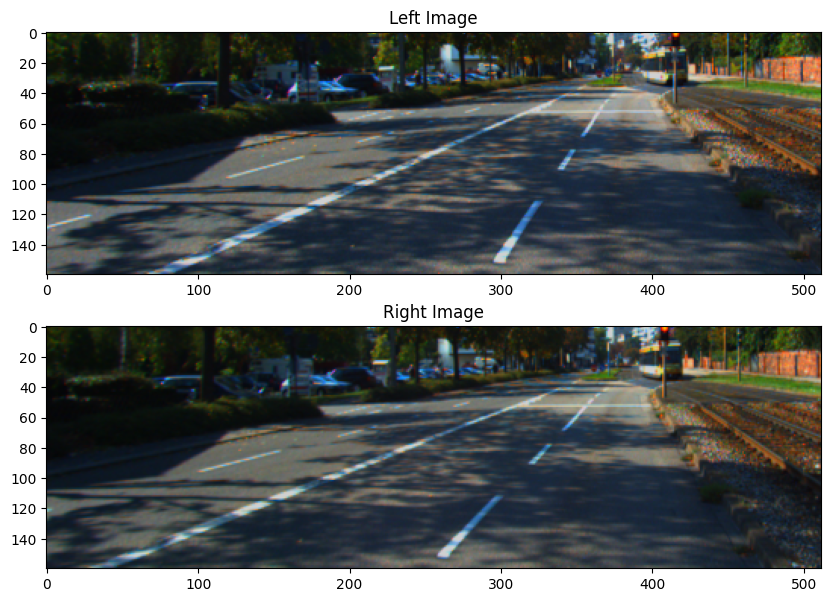

In [79]:
# Load training dataset
train_dev_dataset, test_dev_dataset = load_data('dev', 'real')
print(len(train_dev_dataset),len(test_dev_dataset) )

stereo_train_dataloader = DataLoader(train_dev_dataset, shuffle=True, batch_size=16)
stereo_test_dataloader = DataLoader(test_dev_dataset, shuffle=False, batch_size=16)

print(f"small test set has {len(stereo_train_dataloader.dataset)} train images, {len(stereo_test_dataloader.dataset)} test images")

imgL, imgR = stereo_train_dataloader.dataset[0]
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.title("Left Image")
plt.imshow(imgL.squeeze().permute(1,2,0))
plt.subplot(212)
plt.title("Right Image")
plt.imshow(imgR.squeeze().permute(1,2,0))
plt.show()


The following are the stereo images containing the transformations applied. 

sanity test set has 1 train images, 1 test images


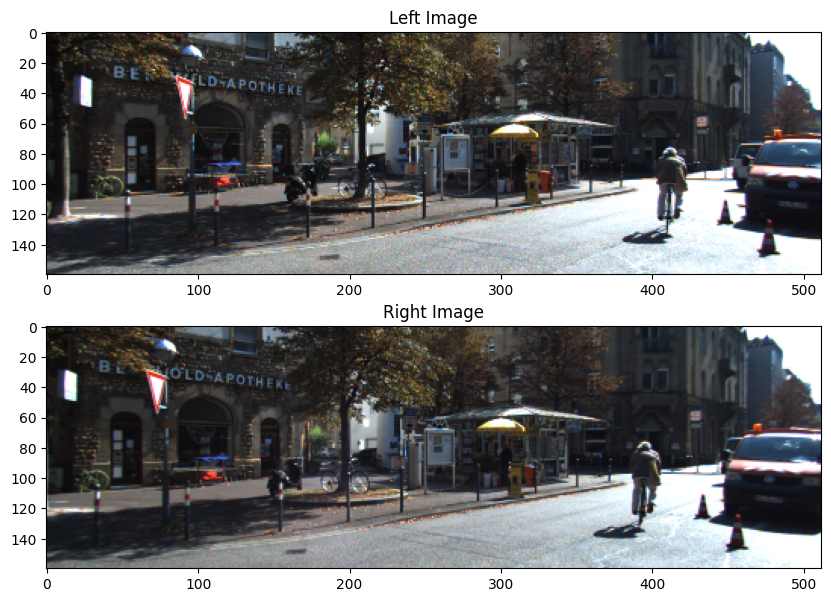

In [48]:
# Load training dataset
train_dev_dataset, test_dev_dataset = load_data('dev', type='sanity')

sanity_train_dataloader = DataLoader(train_dev_dataset, shuffle=True, batch_size=16)
sanity_test_dataloader = DataLoader(test_dev_dataset, shuffle=True, batch_size=16)

print(f"sanity test set has {len(sanity_train_dataloader.dataset)} train images, {len(sanity_test_dataloader.dataset)} test images")

imgL, imgR = sanity_train_dataloader.dataset[0]
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.title("Left Image")
plt.imshow(imgL.squeeze().permute(1,2,0))
plt.subplot(212)
plt.title("Right Image")
plt.imshow(imgR.squeeze().permute(1,2,0))
plt.show()

# 2. Net Architecture

The purpose of the bilinear sampler in our case is to create the second image in the stereo pair given the first image and the disparity map. Our bilinear sampler offsets the pixels in the x-direction for the first stereo image by the disparity map. If the offset location does not result in the exact center of a pixel, it takes a weighted average of the surrounding pixels. By obtaining the reconstructed second image, we can determine how well our model creates a disparity map by evaluating the similarity between the reconstructed image and the actual second image in the stereo pair.

In [49]:
def bilinear_sampler(src, disp):
  batch = src.shape[0]
  height = src.shape[2]
  width = src.shape[3]

  affine_matrices = torch.zeros((batch, 2, 3))
  affine_matrices[:, 0, 0] = 1.0
  affine_matrices[:, 1, 1] = 1.0


  grid = torch.nn.functional.affine_grid(affine_matrices, src.size()).to(device)
  grid_x = grid[:,:, :, 0]
  disp = disp.squeeze(1)
  grid_x = torch.add(grid_x, disp)
  grid_x = grid_x.unsqueeze(-1)
  grid_y  = (grid[:,:, :, 1]).unsqueeze(-1)
  res = torch.cat([grid_x, grid_y], 3)
  retval = F.grid_sample(src, res)
  return retval
  # disp are array of values 0..1 representing how far to go to the right (+x dir)

In [50]:
from piqa import SSIM

#develop neural net architecture 
class SSIM_Loss(SSIM):
  def forward(self, x, y):
    return 1. - super().forward(x, y)

class MyNet(nn.Module):
    def __init__(self, l1_alpha, lr_alpha, dsp_alpha, criterion=None, without=None):
        super(MyNet, self).__init__()

        # This the architecture of the image model we choose to use
        # in this case VGG
        # If you look at the conv_block function each layer has stride 2
        # this halves the dimensions of the image each layer

        #                                         resulting dims
        self.vgg_conv1 = self.conv_block(3, 8, 7) # 8 ch, HxW / 2
        self.vgg_conv2 = self.conv_block(8, 16, 5) # 16 ch, HxW / 4
        self.vgg_conv3 = self.conv_block(16, 32, 3) # 32 ch, HxW / 8
        self.vgg_conv4 = self.conv_block(32, 64, 3) # 64 ch, HxW / 16
        self.vgg_conv5 = self.conv_block(64, 128, 3) # 128 ch, HxW / 32

        # next we upsample on the way back to the original dimension of the image
        self.upconv5 = self.upconv_block(128, 64, 3, 2)
        self.upconv4 = self.upconv_block(64, 32, 3, 2)
        self.upconv3 = self.upconv_block(32, 16, 3, 2)
        self.upconv2 = self.upconv_block(16, 8, 3, 2)
        self.upconv1 = self.upconv_block(8, 4, 3, 2)

        self.conv5 = nn.Conv2d(128,64,kernel_size=3,stride=1, padding='same')
        self.conv4 = nn.Conv2d(64,32,kernel_size=3,stride=1, padding='same')
        self.conv3 = nn.Conv2d(32+2,16,kernel_size=3,stride=1, padding='same')
        self.conv2 = nn.Conv2d(16+2,8,kernel_size=3,stride=1, padding='same')
        self.conv1 = nn.Conv2d(4+2,4,kernel_size=3,stride=1, padding='same')

        # these convolutions are responsible for creating the disparities map
        # used to reconstruct the right image

        # note that we generate 4 of them.
        self.disp_conv4 = self.disp_block(32) # 
        self.udisp4 = nn.Upsample(scale_factor=2, mode='nearest')

        self.disp_conv3 = self.disp_block(16)
        self.udisp3 = nn.Upsample(scale_factor=2, mode='nearest')

        self.disp_conv2 = self.disp_block(8)
        self.udisp2 = nn.Upsample(scale_factor=2, mode='nearest')

        self.disp_conv1 = self.disp_block(4)
        self.l1_alpha = l1_alpha
        self.lr_alpha = lr_alpha
        self.dsp_alpha = dsp_alpha
        self.without = without

        self.alpha = 0.5
        self.SSIM = SSIM_Loss()
    
    def disp_block(self, num_in_layers):
      return nn.Sequential(
          nn.Conv2d(num_in_layers, 2, kernel_size=3,stride=1,padding='same'),
          nn.Tanh() # to ensure values between -1.0 and 1.0
      )

    # Convolution block used for VGG
    # due to memory constraints only using a single layer, but usually there would be 2
    def conv_block(self, num_in_layers, num_out_layers, kernel_size):
      return nn.Sequential(
        nn.Conv2d(num_in_layers, num_out_layers,padding=(kernel_size-1)//2,kernel_size=kernel_size,stride=2),
        nn.ReLU()
        # TODO: get more GPU memory
        #nn.Conv2d(num_out_layers, num_out_layers, kernel_size=kernel_size,stride=1,padding='same'),
        #nn.ReLU()
      )

    # Up convolution block used to construct the disparities.
    def upconv_block(self, num_in_layers, num_out_layers, kernel_size, scale):
      return nn.Sequential(
          nn.Upsample(scale_factor=scale, mode='nearest'),
          nn.Conv2d(num_in_layers, num_out_layers, kernel_size, stride=1, padding='same')
      )

    # This is used so we can compare the disparity at each dimension with scaled version of its
    # target right image. Explained in the loss we take the loss calculation at 4 different points
    # of the pipeline to get a robust loss
    def get_scaled_imgs(self, imgL):
      h, w = imgL.shape[2], imgL.shape[3]
      return [imgL, transforms.Resize(size=(h//2, w//2))(imgL), transforms.Resize(size=(h//4, w//4))(imgL), transforms.Resize(size=(h//8, w//8))(imgL)]
    
    # Here we split the data and make the first element the left to right disp
    # and the second the right to left disp. This is the convention chosen arbitrarily
    def get_lr_disp(self, disps):
      return disps[:,0,:,:].unsqueeze(1), disps[:,1,:,:].unsqueeze(1)

    # reconstruct the right image from imgL and lr_disp
    def gen_img_r(self, imgL, lr_disp):
      return bilinear_sampler(imgL, lr_disp)

    # reconstruct the left image from imgR and rl_disp, note the negative sign
    # since we shift backwards instead of forwards now
    def gen_img_l(self, imgR, disp):
      return bilinear_sampler(imgR, -disp)
      
    def get_disp_smoothness(self, disps, imgs):
      # shift disparities
      x_shift_disps, y_shift_disps = [], []
      for i in range(4):
        x_shift_disps += [self.gradient_x(disps[i])]
        y_shift_disps += [self.gradient_y(disps[i])]
      
      x_weights, y_weights = [], []
      for i in range(4):
        x_weights += [torch.exp(torch.mean(torch.abs(self.gradient_x(imgs[i])), dim=1))]
        y_weights += [torch.exp(torch.mean(torch.abs(self.gradient_y(imgs[i])), dim=1))]

      x_smooth, y_smooth = [], []
      for i in range(4):
        x_smooth += [x_shift_disps[i]*x_weights[i]]
        y_smooth += [y_shift_disps[i]*y_weights[i]]
      
      return x_smooth + y_smooth

    def gradient_x(self, disp):
      return torch.roll(disp, -1, 3) - disp
    def gradient_y(self, disp):
      return torch.roll(disp, -1, 2) - disp

    #forward pass of our model
    def forward(self, imgL, imgR=None, criterion=None):
      skip1 = self.vgg_conv1(imgL) # skip1 = 8ch HW/2
      skip2 = self.vgg_conv2(skip1) # skip2 = 16ch HW/4
      skip3 = self.vgg_conv3(skip2) # skip3 = 32ch HW/8
      skip4 = self.vgg_conv4(skip3) # skip4 = 64ch HW/16
      h = self.vgg_conv5(skip4) # h = 128ch HW/32

      upconv5 = self.upconv5(h) # upconv5 = 64ch, HW/16
      concat5 = torch.cat([upconv5, skip4], 1) # concat = 128ch, HW/16
      iconv5 = self.conv5(concat5)

      upconv4 = self.upconv4(iconv5)
      concat4 = torch.cat([upconv4, skip3], 1)
      iconv4 = self.conv4(concat4)
      disp4 = 0.3*self.disp_conv4(iconv4)
      udisp = self.udisp4(disp4)

      upconv3 = self.upconv3(iconv4)
      concat3 = torch.cat([upconv3, skip2, udisp], 1)
      iconv3 = self.conv3(concat3)
      disp3 = 0.3*self.disp_conv3(iconv3)
      udisp = self.udisp3(disp3)

      upconv2 = self.upconv2(iconv3)
      concat2 = torch.cat([upconv2, skip1, udisp], 1)
      iconv2 = self.conv2(concat2)
      disp2 = 0.3*self.disp_conv2(iconv2)
      udisp = self.udisp2(disp2)

      upconv1 = self.upconv1(iconv2)
      concat1 = torch.cat([upconv1,udisp], 1)
      iconv1 = self.conv1(concat1)
      disp1 = 0.3*self.disp_conv1(iconv1)

      disps = [disp1, disp2, disp3, disp4]
        
      if imgR == None:
        return disp1
        
        
      # ASSUME imgR no None and train = true or validation

      # LOSS CALCULATION TIME
      scaled_imgs_l = self.get_scaled_imgs(imgL)
      scaled_imgs_r = self.get_scaled_imgs(imgR)

      lr_disps, rl_disps = [], []

      # get Left and Right Disparities
      for i in range(4):
        ld, rd = self.get_lr_disp(disps[i])
        lr_disps += [ld]
        rl_disps += [rd]

      ##### Intermediate maps needed for loss
      ## Generate estimate reconstructed images from disparities
      recon_r_imgs = [self.gen_img_r(scaled_imgs_l[i], lr_disps[i]) for i in range(4)]
      recon_l_imgs = [self.gen_img_l(scaled_imgs_r[i], rl_disps[i]) for i in range(4)]

      ## Generate maps used for LR consistency loss calculation
      r_to_l_disp = [self.gen_img_l(lr_disps[i], rl_disps[i]) for i in range(4)]
      l_to_r_disp = [self.gen_img_r(rl_disps[i], lr_disps[i]) for i in range(4)]

      ## Generate disparity smoothness values
      disp_smooth_l = self.get_disp_smoothness(r_to_l_disp, scaled_imgs_l)
      disp_smooth_r = self.get_disp_smoothness(l_to_r_disp, scaled_imgs_r)

      ## calculate loss

      # L1 Loss
      l1_loss = 0.0
      image_loss = 0.0
      ssim_loss = 0.0
      for i in range(4):
        image_loss += criterion(recon_r_imgs[i], scaled_imgs_r[i]) 
        image_loss += criterion(recon_l_imgs[i], scaled_imgs_l[i]) 
        ssim_loss += self.SSIM(recon_l_imgs[i], scaled_imgs_l[i])
        ssim_loss += self.SSIM(recon_r_imgs[i], scaled_imgs_r[i])
        
          #validation mode
      if self.training == False:
            return image_loss

      l1_loss = self.alpha*ssim_loss + (1-self.alpha)*image_loss

      # LR consistency
      lr_consistency_loss = 0.0
      for i in range(4):
        lr_consistency_loss += criterion(r_to_l_disp[i], rl_disps[i])
        lr_consistency_loss += criterion(l_to_r_disp[i], lr_disps[i])
      
      ## Disparity smoothness
      disp_smooth_loss = 0.0
      for i in range(4):
        disp_smooth_loss += torch.mean(torch.abs(disp_smooth_l[i]))/2**i
        disp_smooth_loss += torch.mean(torch.abs(disp_smooth_r[i]))/2**i

      if self.without == 'lr_alpha':
        loss = self.l1_alpha * l1_loss + self.dsp_alpha * disp_smooth_loss
      elif self.without == 'disp_smooth':
        loss = self.l1_alpha * l1_loss + self.lr_alpha * lr_consistency_loss
      elif self.without == 'both':
        loss = self.l1_alpha * l1_loss 
      else:
        loss = self.l1_alpha * l1_loss + self.lr_alpha * lr_consistency_loss + self.dsp_alpha * disp_smooth_loss
      return loss
    

In [61]:
#initalize various models
sanity_criterion = nn.L1Loss().to(device)
sanity_model = MyNet(1.0, 1.0, 0.8).to(device)
sanity_model.eval()
sanity_optimzer = torch.optim.Adam(sanity_model.parameters())

# currently using Adam but was experimenting with SGD
#my_optimzer = torch.optim.SGD(my_model.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4)

In [62]:
#display one stereo pair image in dataloader, the disparity map and the
#the reconstructed right image
def sanity_test(model, dataloader):
  model.eval()
  for imgL, imgR in dataloader:
    imgL = imgL.to(device)
    res = model(imgL)
  disp = (res[:,0,:,:].unsqueeze(1))
  disp = disp.to(device)
  recon_r = bilinear_sampler(imgL, disp).cpu()
  imgL = imgL.cpu()
  disp = disp.cpu()

  plt.figure(figsize=(10,15))
  plt.subplot(411)
  plt.title("Left Input Image")
  plt.imshow(imgL[0].squeeze().permute(1,2,0))
  plt.subplot(412)
  plt.title("Generated Depth Map")
  plt.imshow(disp[0].squeeze().detach().numpy())
  plt.colorbar()
  plt.subplot(413)
  plt.title("Reconstructed Image")
  plt.imshow(recon_r[0].detach().permute(1,2,0))
  plt.subplot(414)
  plt.title("Target Right Image")
  plt.imshow(imgR[0].squeeze().permute(1,2,0))

## Sanity Check

We train the model on the `sanity_train_dataloader` that consists of a single test image. 
This is a form of sanity check to determine if the model is working as expected. We can see without any training there is little to no information about the depth but it resembles some parts of the original image. Also note that the values of the untrained model are very low seen in the colour bar, this results in very little shift applied to the left image.

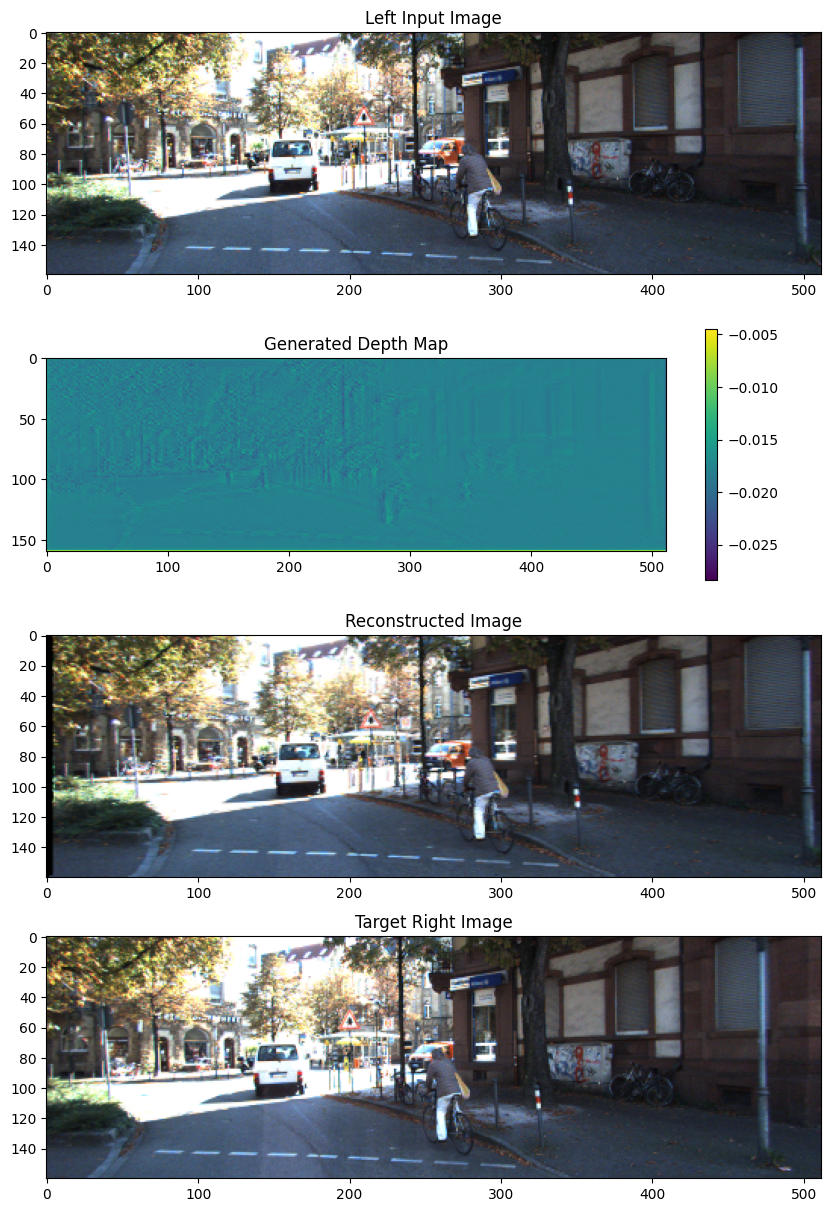

In [63]:
#non trained nn sanity test
sanity_test(sanity_model, sanity_test_dataloader)

# 3. Training
The following the generic training code used. We see that when training we feed in both the left and right image to the model to allow it to learn the transformations. When two images are passed it returns the loss. However when evaluating our model can also accept only the right image and in this case the disparity map is returned.

In [64]:
!mkdir -p model_checkpoints

#log_interval = 50

def train(dataloader, epoch, model, optimizer, criterion, isTrain=True):
    if(isTrain):
        model.train() # set to training mode
    else:
        model.eval()
    train_loss = 0
    for batch_idx, (imgL, imgR) in enumerate(dataloader):
        imgL, imgR = imgL.to(device), imgR.to(device)
        if(isTrain):
            optimizer.zero_grad()
        loss = model(imgL, imgR, criterion)
        if(isTrain):
            loss.backward()
        train_loss += loss.item()
        if(isTrain):
            optimizer.step()

        #if batch_idx % log_interval == 0:
        #    print(f"Epoch: {epoch}({batch_idx * len(imgL)}/{len(dataloader)})\tLoss: {loss.item()}\tAverage Train Loss: {train_loss / ((batch_idx+1)*len(imgL))}")

    average_train_loss = train_loss / len(dataloader.dataset)
    return average_train_loss


In [65]:
epochs = 2000
average_train_loss = []
best_train_loss = 1
for epoch in range(1, epochs+1):
    loss = train(sanity_train_dataloader, epoch, sanity_model, sanity_optimzer, sanity_criterion)
    print(f"Epoch: {epoch}, Average Train Loss: {loss}")
    average_train_loss += [loss]
    if best_train_loss > loss:
        torch.save(sanity_model, 'model_checkpoints/sanity_model.pt')

Epoch: 1, Average Train Loss: 3.139474868774414
Epoch: 2, Average Train Loss: 3.0037307739257812
Epoch: 3, Average Train Loss: 2.833242893218994
Epoch: 4, Average Train Loss: 2.796372413635254
Epoch: 5, Average Train Loss: 2.6284921169281006
Epoch: 6, Average Train Loss: 2.5858867168426514
Epoch: 7, Average Train Loss: 2.568730592727661
Epoch: 8, Average Train Loss: 2.480226993560791
Epoch: 9, Average Train Loss: 2.4027459621429443
Epoch: 10, Average Train Loss: 2.4011785984039307
Epoch: 11, Average Train Loss: 2.3620424270629883
Epoch: 12, Average Train Loss: 2.2728772163391113
Epoch: 13, Average Train Loss: 2.179932117462158
Epoch: 14, Average Train Loss: 2.1121666431427
Epoch: 15, Average Train Loss: 2.1609127521514893
Epoch: 16, Average Train Loss: 2.1894359588623047
Epoch: 17, Average Train Loss: 2.1737680435180664
Epoch: 18, Average Train Loss: 2.1392316818237305
Epoch: 19, Average Train Loss: 2.104261636734009
Epoch: 20, Average Train Loss: 2.098536968231201
Epoch: 21, Average T

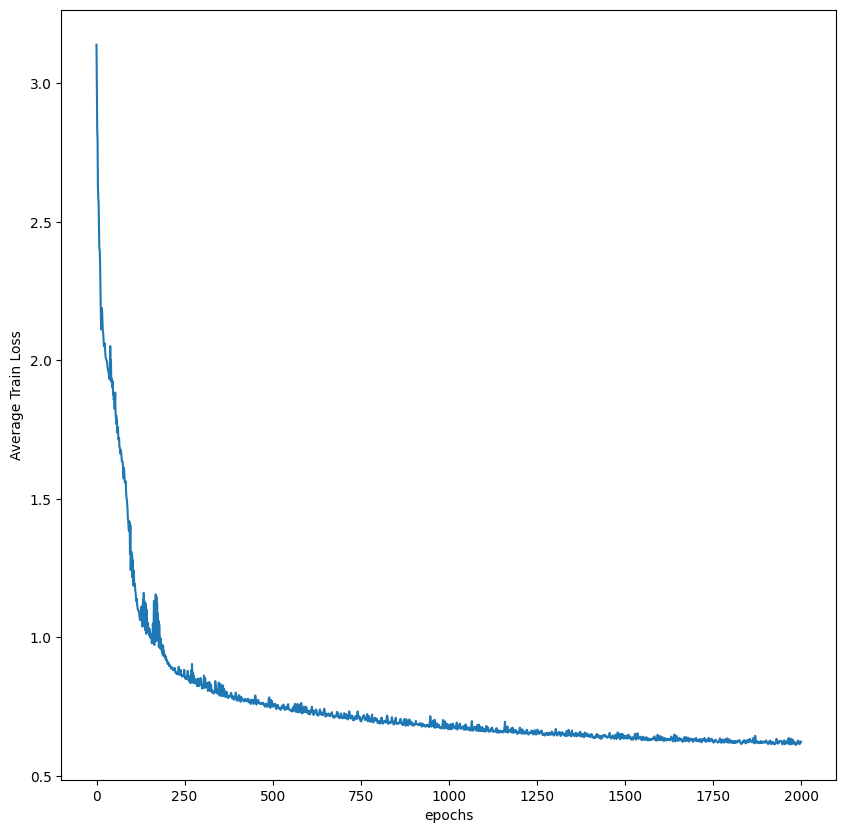

In [69]:
plt.figure(figsize=(10,10))
plt.plot(average_train_loss)
plt.xlabel("epochs")
plt.ylabel("Average Train Loss")
plt.show()

## Sanity Train Set
Now after training on the sanity set we see a much nicer disparity map generated from this model. It is more coherent and consistent with basic features of the image. This includes the gradient between the ground and the sky as well as some features such as walls, cars, and people.

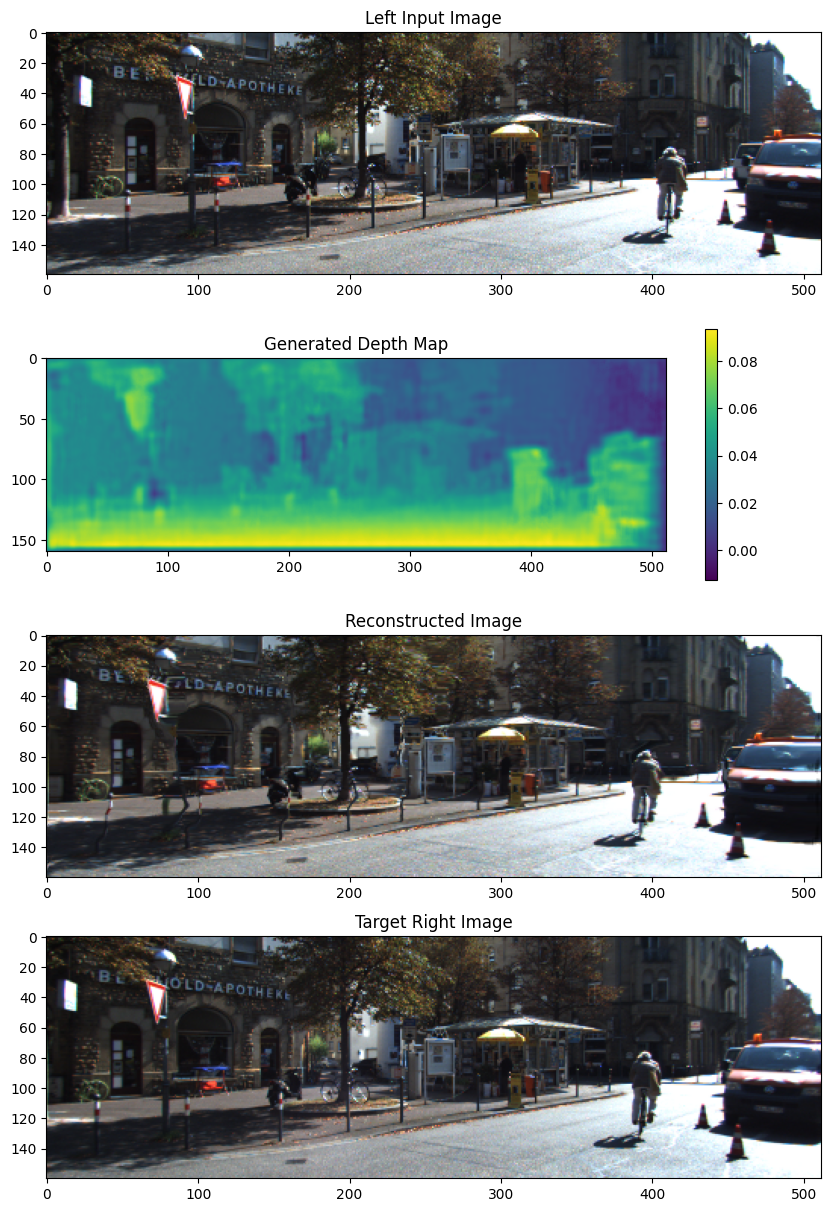

In [67]:
sanity_model = torch.load('model_checkpoints/sanity_model.pt')
sanity_test(sanity_model, sanity_train_dataloader)

However now when we try to predict with an image it has never seen before we run into problems. This is expected however since the training set was so limited. Knowing we're are getting relatively reasonable answers we can start training with larger models.

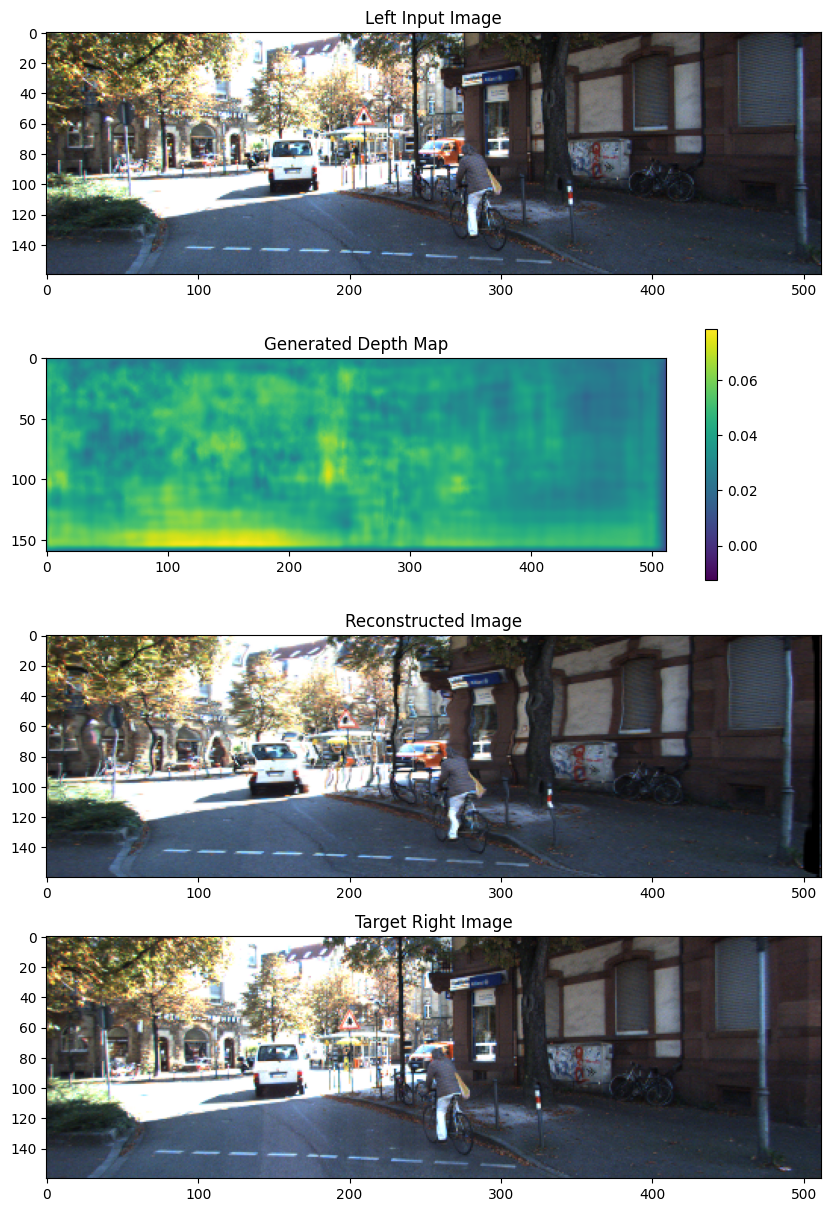

In [68]:
#test on another image and on sampleImgRight
sanity_test(sanity_model, sanity_test_dataloader)

## Small dataset
We upgrade our model by training on a dataset with more images this will lead to longer training times, but hopefully a more general model.

## Loss functions
We can also demonstrate the importance of different parts of the loss function by seeing how the model performs wihtout them.

In [35]:
def trainModel(epochs, modelName, model, optimizer, criterion):
    average_train_loss = []
    for epoch in range(1, epochs+1):
        loss = train(stereo_train_dataloader, epoch, model, optimizer, criterion)
        print(f"Epoch: {epoch}, Average Train Loss: {loss}")
        average_train_loss += [loss]
    torch.save(sanity_model, 'model_checkpoints/' + modelName + ".pt")

In [53]:
# Wihout either special loss and only L1 loss
my_criterion = nn.L1Loss().to(device)
l1_model = MyNet(1.0, 1.0, 0.8, without='both').to(device)
l1_model.train()
my_optimzer = torch.optim.Adam(l1_model.parameters())

trainModel(75, 'l1loss', l1_model, my_optimzer, my_criterion)

Epoch: 1, Average Train Loss: 0.01927310107378942
Epoch: 2, Average Train Loss: 0.018290679393219333
Epoch: 3, Average Train Loss: 0.017422220363828088
Epoch: 4, Average Train Loss: 0.016464904225620396
Epoch: 5, Average Train Loss: 0.01502821778679246
Epoch: 6, Average Train Loss: 0.014637392000518602
Epoch: 7, Average Train Loss: 0.01395094312205086
Epoch: 8, Average Train Loss: 0.013700407479521974
Epoch: 9, Average Train Loss: 0.01349893041862333
Epoch: 10, Average Train Loss: 0.013146609672761052
Epoch: 11, Average Train Loss: 0.013110644647995924
Epoch: 12, Average Train Loss: 0.012930445510522906
Epoch: 13, Average Train Loss: 0.012838856100596185
Epoch: 14, Average Train Loss: 0.01316919895335757
Epoch: 15, Average Train Loss: 0.012594579550612897
Epoch: 16, Average Train Loss: 0.012473985442816112
Epoch: 17, Average Train Loss: 0.012404690149525435
Epoch: 18, Average Train Loss: 0.012486542997764926
Epoch: 19, Average Train Loss: 0.01239677323406473
Epoch: 20, Average Train Lo

In [54]:
# Only with L1 loss and lr_alpha
my_criterion = nn.L1Loss().to(device)
l1_lralpha_model = MyNet(1.0, 1.0, 0.8, without='lr_alpha').to(device)
l1_lralpha_model.train()
my_optimzer = torch.optim.Adam(l1_lralpha_model.parameters())

trainModel(75, 'l1_lralpha', l1_lralpha_model, my_optimzer, my_criterion)

Epoch: 1, Average Train Loss: 0.01977749669243929
Epoch: 2, Average Train Loss: 0.018696666753600006
Epoch: 3, Average Train Loss: 0.01843260124160795
Epoch: 4, Average Train Loss: 0.017534672334185385
Epoch: 5, Average Train Loss: 0.016762707726102034
Epoch: 6, Average Train Loss: 0.015918005986407233
Epoch: 7, Average Train Loss: 0.015198080907008745
Epoch: 8, Average Train Loss: 0.01493532284819332
Epoch: 9, Average Train Loss: 0.014694368212425401
Epoch: 10, Average Train Loss: 0.014540799924368348
Epoch: 11, Average Train Loss: 0.014623058897982663
Epoch: 12, Average Train Loss: 0.014170869085181684
Epoch: 13, Average Train Loss: 0.013789056466954221
Epoch: 14, Average Train Loss: 0.013546148129494867
Epoch: 15, Average Train Loss: 0.013608798219708939
Epoch: 16, Average Train Loss: 0.013439160651386443
Epoch: 17, Average Train Loss: 0.013453467030806736
Epoch: 18, Average Train Loss: 0.01323467905451011
Epoch: 19, Average Train Loss: 0.013192023848255623
Epoch: 20, Average Train 

In [55]:
# Only with L1 loss and disp_smooth
my_criterion = nn.L1Loss().to(device)
l1_dispSmooth_model = MyNet(1.0, 1.0, 0.8, without='disp_smooth').to(device)
l1_dispSmooth_model.train()
my_optimzer = torch.optim.Adam(l1_dispSmooth_model.parameters())

trainModel(75, 'l1_dispSmooth', l1_dispSmooth_model, my_optimzer, my_criterion)

Epoch: 1, Average Train Loss: 0.02934720573390102
Epoch: 2, Average Train Loss: 0.020375353053926983
Epoch: 3, Average Train Loss: 0.019371492726336547
Epoch: 4, Average Train Loss: 0.019102887033976314
Epoch: 5, Average Train Loss: 0.01906196316669788
Epoch: 6, Average Train Loss: 0.018931433833393223
Epoch: 7, Average Train Loss: 0.01869789205793965
Epoch: 8, Average Train Loss: 0.018188735545781265
Epoch: 9, Average Train Loss: 0.018037189306808133
Epoch: 10, Average Train Loss: 0.017839699983596802
Epoch: 11, Average Train Loss: 0.017803208634422273
Epoch: 12, Average Train Loss: 0.017557997985079718
Epoch: 13, Average Train Loss: 0.017190153638375203
Epoch: 14, Average Train Loss: 0.017425005781254645
Epoch: 15, Average Train Loss: 0.01686020591382171
Epoch: 16, Average Train Loss: 0.01638252730739073
Epoch: 17, Average Train Loss: 0.015674259609841774
Epoch: 18, Average Train Loss: 0.015521033553619666
Epoch: 19, Average Train Loss: 0.015113360107604867
Epoch: 20, Average Train L

In [56]:
# With both special loss and only L1 loss
my_criterion = nn.L1Loss().to(device)
complete_model = MyNet(1.0, 1.0, 0.8).to(device)
complete_model.train()
my_optimzer = torch.optim.Adam(complete_model.parameters())
trainModel(75, 'complete', complete_model, my_optimzer, my_criterion)

Epoch: 1, Average Train Loss: 0.02497336543354161
Epoch: 2, Average Train Loss: 0.021928698044421487
Epoch: 3, Average Train Loss: 0.02140279097750618
Epoch: 4, Average Train Loss: 0.020895107755801775
Epoch: 5, Average Train Loss: 0.01959264927244714
Epoch: 6, Average Train Loss: 0.01922327697936899
Epoch: 7, Average Train Loss: 0.01900488875009037
Epoch: 8, Average Train Loss: 0.01895810691193021
Epoch: 9, Average Train Loss: 0.018689158547848354
Epoch: 10, Average Train Loss: 0.018478733147202383
Epoch: 11, Average Train Loss: 0.018275845534687113
Epoch: 12, Average Train Loss: 0.017771122420405988
Epoch: 13, Average Train Loss: 0.017322523402551884
Epoch: 14, Average Train Loss: 0.01710883299802942
Epoch: 15, Average Train Loss: 0.016823257797318632
Epoch: 16, Average Train Loss: 0.01677113892407435
Epoch: 17, Average Train Loss: 0.01726558001718838
Epoch: 18, Average Train Loss: 0.016617605661993978
Epoch: 19, Average Train Loss: 0.015918894887410405
Epoch: 20, Average Train Loss:

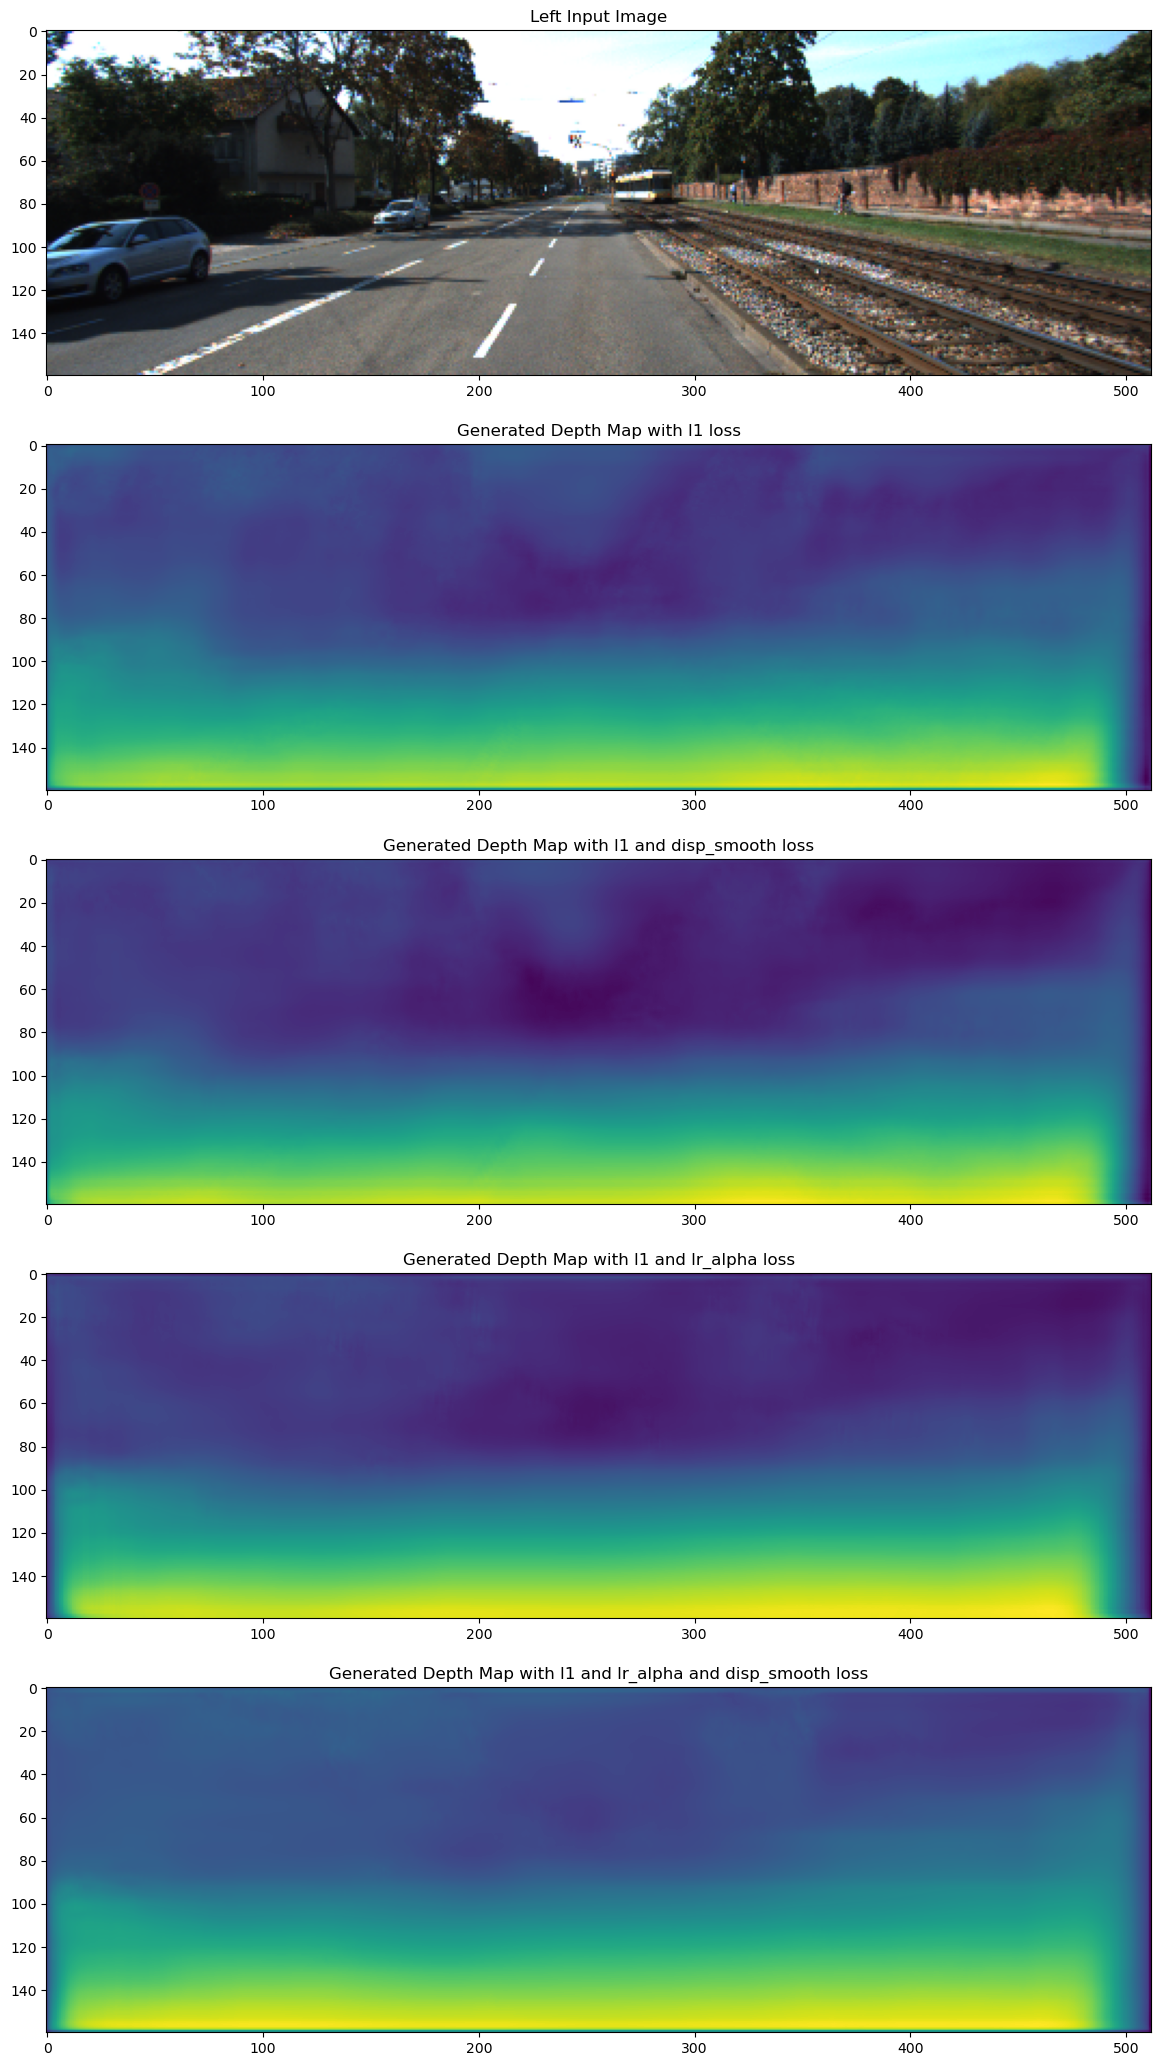

In [57]:
#display image and corresponding diparity map
recon_images = []
disps = []
models_name = [[l1_model, "l1 loss"], 
              [l1_lralpha_model, "l1 and disp_smooth loss"],
              [l1_dispSmooth_model, "l1 and lr_alpha loss"],
              [complete_model, "l1 and lr_alpha and disp_smooth loss"]]
              
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(25, 26))

for imgL, imgR in sanity_test_dataloader:
    axs[0].imshow(imgL[0].squeeze().permute(1,2,0))
    #axs[0, 1].imshow(imgR[0].squeeze().permute(1,2,0))
    axs[0].set_title('Left Input Image')
    #axs[0, 1].set_title('Target Right Image')

for i in range(len(models_name)):
    model = models_name[i][0]
    name = models_name[i][1]
    for imgL, imgR in sanity_test_dataloader:
        imgL = imgL.to(device)
        res = model(imgL)
        disp = (res[:,0,:,:].unsqueeze(1))
        disp = disp.to(device)
        recon_r = bilinear_sampler(imgL, disp).cpu()
        imgL = imgL.cpu()
        disp = disp.cpu()
        axs[i+1].imshow(disp[0].squeeze().detach().numpy())
        #axs[i+1, 1].imshow(recon_r[0].detach().permute(1,2,0))
        axs[i+1].set_title('Generated Depth Map with '+ name)
        #axs[i+1, 1].set_title('Reconstructed Image with '+ name)
        

# Show the figure
plt.show()

Calculate the reconstructed loss on validation set and determine which loss function provided the best results

In [61]:
models_name = [[l1_model, "l1 loss function"], 
              [l1_lralpha_model, "l1 and disp_smooth loss function"],
              [l1_dispSmooth_model, "l1 and lr_alpha loss function"],
              [complete_model, "l1 and lr_alpha and disp_smooth loss function"]]

for i in range(len(models_name)):
    model = models_name[i][0]
    model.eval()
    name = models_name[i][1]
    my_criterion = nn.L1Loss().to(device)
    loss = train(stereo_test_dataloader, 1, model, None, my_criterion, False)
    print(f"Average Train Loss with {name}: {loss}")


Average Train Loss with l1 loss function: 0.03149507282411351
Average Train Loss with l1 and disp_smooth loss function: 0.031644657254219055
Average Train Loss with l1 and lr_alpha loss function: 0.03330018371343613
Average Train Loss with l1 and lr_alpha and disp_smooth loss function: 0.03307314085609773


In [64]:
#save for future use
torch.save(l1_model, 'model_checkpoints/l1loss.pt')
torch.save(l1_lralpha_model, 'model_checkpoints/l1_lralpha.pt')
torch.save(l1_dispSmooth_model, 'model_checkpoints/l1_dispSmooth.pt')
torch.save(complete_model, 'model_checkpoints/complete.pt')

After running testing various model with different loss functions on the validation set and obtaining the image loss (ie how close the image resembles original) we can see that the loss function containing only l1 yield in the smallest loss function. The higher loss combining all 3 loss function together may result due to over smoothing thus resulting in a greater loss. 

# 4. Extensions

Some other experiment that could have been performed to improve determine the weighing for each loss function, however, due to limitation of hardware we were unable to train more models with varying levels of weights per loss component. Performing this test may have changed our result on the most effective loss function.

There are many practical real-world scenarios where depth estimation is required, such as in self-driving cars. Traditionally, expensive equipment and sensors such as LIDAR and stereo cameras have been used to determine depth, but using monocular depth estimation can be used as an alternative. By using a single camera, it is possible to determine the depth of surrounding objects in a cost-effective way. Using multiple cameras to determine the depth of objects can be impractical due to the real-time nature of the problem. This is because multiple cameras require sophisticated synchronization and calibration, which can be challenging to achieve in real-world applications. Therefore, monocular depth estimation has become an attractive alternative for real-time applications such as self-driving cars.

Moreover, monocular depth estimation has the advantage of being able to estimate depth in a wide range of lighting conditions and environments. It can work well even in low-light or adverse weather conditions, which can be a major limitation for other depth sensing technologies. Additionally, monocular depth estimation can provide accurate depth estimation for both static and dynamic scenes, making it a versatile technology for a range of applications.